## PROJECT 1: Conspiracy theories
**Your task**

Given a bunch of comment threads from the r/conspiracies subreddit, develop a set of labels for categorizing them. Labels should be a single word or short phrase. Some threads might fit more than one label.

Use methods from labs so far (keyword analysis, terminology extraction, topic models)
No specific ‘correct’ answer; the process you use to develop the list is more important than the solution.

**Deliverables**

List of labels\
For each label, the number of threads from the dataset that fit that label\
Discuss how the mix of labels has changed over time\
Annotated notebook(s) showing your process plus a brief write-up describing your conclusions

**To turn in:** download your notebooks as HTMLs file (File>Save and Export Notebook as...>HTML) and submit via canvas

In [1]:
import re
from collections import Counter, defaultdict

import nltk
import numpy as np
import pandas as pd
from cytoolz import concat
from tqdm import tqdm

In [2]:
df = pd.read_pickle("/data/conspiracy.pkl")

df['text'] = df['text'].apply(lambda x: re.sub(r'http\S+', '', x)) # remove URLs
df['text'] = df['text'].apply(lambda x: re.sub(r'[^\w\s,]', '', x)) # remove emojis 
df

,date,text
0,2019-08-09 21:58:14,Your post has been removed because it does not...
1,2022-01-15 19:16:00,Ugh I am sick of seeing his face He is so cont...
2,2022-10-24 16:25:16,"Im not saying charges werent used, what I am s..."
3,2016-10-28 15:10:41,Its actually a callback to Tom Cruises moment ...
4,2020-12-12 19:53:11,All caps titles are not permitted as per rule ...
...,...,...
19993,2022-03-03 07:03:00,Cry me a river Im speaking from my personal po...
19994,2021-02-13 08:04:35,Whats the conspiracy All I see are political o...
19995,2016-12-06 19:21:36,Remind people that this shit is larger and mor...
19996,2015-12-06 16:25:01,you do not have time to go tell nasa yourself...


## Tokenize text

Tokenize in two steps: first find multiword expressions and then use them to divide text into 'words'

In [3]:
import spacy
from spacy.matcher import Matcher

nlp = spacy.load(
    "en_core_web_sm", exclude=["parser", "ner", "lemmatizer", "attribute_ruler"]
)

In [4]:
matcher = Matcher(nlp.vocab)
matcher.add(
    "Term",
    [
        [
            {"TAG": {"IN": ["JJ", "NN", "NNS", "NNP"]}},
            {"TAG": {"IN": ["JJ", "NN", "NNS", "NNP", "HYPH"]}, "OP": "*"},
            {"TAG": {"IN": ["NN", "NNS", "NNP"]}},
        ]
    ],
)


def get_phrases(doc):
    spans = matcher(doc, as_spans=True)
    return [tuple(tok.norm_ for tok in span) for span in spans]

## Find candidate terms

In [5]:
#remove the punctuations and covert all the text to lower case

df['text'] = df['text'].apply(lambda x: re.sub(r'[^\w\s]', '', x.lower()))

In [6]:
#remove urls and emojis if any present 
df['text'] = df['text'].apply(lambda x: re.sub(r'http\S+', '', x)) # remove URLs
df['text'] = df['text'].apply(lambda x: re.sub(r'[^\w\s,]', '', x)) # remove emojis

# Unwanted entry
df['text'] = df['text'].apply(lambda x: re.sub(r'sa', '', x))

# remove stop words such as i, me, myself etc
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kothapally/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
docs = nlp.pipe(tqdm(df["text"]), n_process=2, batch_size=5)
candidates = Counter(concat(get_phrases(d) for d in docs))

100%|██████████| 19969/19969 [03:49<00:00, 87.16it/s] 


In [10]:
candidates.most_common(10)

[(('i', "'d"), 19990),
 (('submission', 'statement'), 6592),
 (('many', 'people'), 2561),
 (('link', 'comment'), 1920),
 (('comment', 'submission'), 1906),
 (('contain', 'submission'), 1905),
 (('contain', 'submission', 'statement'), 1905),
 (('comment', 'submission', 'statement'), 1903),
 (('statement', 'bot'), 1902),
 (('submission', 'statement', 'bot'), 1902)]

### Use C-value algorithm to find terms

In [11]:
freqs = defaultdict(Counter)
for c in candidates:
    freqs[len(c)][c] += candidates[c]

In [12]:
def get_subterms(term):
    k = len(term)
    for m in range(k - 1, 1, -1):
        yield from nltk.ngrams(term, m)


def c_value(F, theta):

    termhood = Counter()
    longer = defaultdict(list)

    for k in sorted(F, reverse=True):
        for term in F[k]:
            if term in longer:
                discount = sum(longer[term]) / len(longer[term])
            else:
                discount = 0
            c = np.log2(k) * (F[k][term] - discount)
            if c > theta:
                termhood[term] = c
                for subterm in get_subterms(term):
                    if subterm in F[len(subterm)]:
                        longer[subterm].append(F[k][term])
    return termhood

In [13]:
terms = c_value(freqs, theta=100)

In [16]:
terms.most_common(10)

[(('i', "'d"), 19880.5),
 (('link', 'comment', 'submission', 'statement', 'bot', 'replies', 'pms'),
  5333.974351909448),
 (('submission', 'statement'), 4689.5),
 (('contain', 'submission', 'statement'), 3019.353563873802),
 (('moderators', 'subreddit', 'questions', 'concerns'), 2808.0),
 (('many', 'people'), 2561.0),
 (('mesge', 'error'), 1901.0),
 (('mods', 'modmail'), 1901.0),
 (('social', 'media'), 1754.0),
 (('united', 'states'), 1572.5)]

In [15]:
terms.most_common()[-10:]

[(('legal', 'system'), 102.0),
 (('project', 'veritas'), 102.0),
 (('death',
   'panels',
   'death',
   'panels',
   'death',
   'panels',
   'death',
   'panels',
   'death',
   'panels',
   'death',
   'panels',
   'death',
   'panels',
   'death',
   'panels',
   'death',
   'panels',
   'death',
   'panels',
   'death',
   'panels',
   'death',
   'panels',
   'death',
   'panels',
   'death',
   'panels',
   'death',
   'panels',
   'death',
   'panels',
   'death',
   'panels'),
  101.74925682500678),
 (('george', 'w', 'bush'), 101.43760004615399),
 (('child', 'sex', 'trafficking'), 101.43760004615399),
 (('world', 'war', 'ii'), 101.43760004615399),
 (('health', 'problems'), 101.0),
 (('logical', 'fallacy'), 101.0),
 (('child', 'pornography'), 101.0),
 (('wrong', 'way'), 101.0)]

## save terms

In [17]:
with open("terms.txt", "w") as f:
    for term in terms:
        print(" ".join(term), file=f)

The terms in top 10 most common terms are from the automated bot comment which removed the comment threads that contain theories which are not right for the community.

After filtering through theta value, the least common terms are related to child abuse, world war ii, legal systems and health.

## Second part of tokenization: tokenize texts using terms we just found

In [18]:
from tokenizer import MWETokenizer

tokenizer = MWETokenizer(t.strip() for t in open("terms.txt"))

In [19]:
df["tokens"] = [tokenizer.tokenize(txt) for txt in tqdm(df["text"])]

100%|██████████| 19969/19969 [00:28<00:00, 709.47it/s] 


## TOPIC MODEL

Next up: Using our tokenized texts, build a topic model

In [20]:
import tomotopy as tp

In [21]:
k = 35
min_df = 100
rm_top = 75
tw = tp.TermWeight.ONE
alpha = 0.1
eta = 0.01
tol = 1e-5

In [22]:
%%time

mdl = tp.LDAModel(k=k, min_df=min_df, rm_top=rm_top, tw=tw, alpha=alpha, eta=eta)

for toks in df["tokens"]:
    mdl.add_doc(toks)

mdl.train(0)
last = mdl.ll_per_word
print(f"{0:5d} LL = {last:8.4f}", flush=True)

for i in range(50, 5000, 50):
    mdl.train(50, workers=4)
    ll = mdl.ll_per_word
    print(f"{i:5d} LL = {ll:8.4f}", flush=True)
    if ll - last < tol:
        break
    else:
        last = ll

    0 LL = -12.0732
   50 LL =  -9.3051
  100 LL =  -9.1575
  150 LL =  -9.0731
  200 LL =  -9.0240
  250 LL =  -8.9930
  300 LL =  -8.9745
  350 LL =  -8.9595
  400 LL =  -8.9492
  450 LL =  -8.9414
  500 LL =  -8.9343
  550 LL =  -8.9294
  600 LL =  -8.9308
CPU times: user 4min 41s, sys: 832 ms, total: 4min 42s
Wall time: 1min 25s


In [25]:
", ".join(mdl.removed_top_words)

"not, i, do, people, like, s, would, one, are, think, m, get, know, you, even, 'd, that, us, see, also, have, going, could, right, u_r_l, want, make, really, well, way, can, go, much, time, does, something, still, they, trump, never, believe, need, actually, got, is, years, take, good, look, anything, shit, sure, post, things, back, point, every, someone, government, world, ying, nothing, lol, many, thing, will, use, there, mean, made, he, work, everyone, money, yes"

In [26]:
import matplotlib.pyplot as plt
from scipy.spatial import distance
from sklearn.manifold import MDS, TSNE


def plot_topics(mdl, method="tsne", figsize=7):

    fig = plt.figure(figsize=(figsize, figsize))

    # x, y coords
    term_topics_dist = np.stack([mdl.get_topic_word_dist(k) for k in range(mdl.k)])
    if method == "mds":
        dist = distance.squareform(distance.pdist(term_topics_dist, "jensenshannon"))
        coords = MDS(2, dissimilarity="precomputed").fit_transform(dist)
    elif method == "tsne":
        if mdl.k <= 20:
            p = mdl.k - 1
        else:
            p = 20
        coords = TSNE(
            2,
            metric=distance.jensenshannon,
            perplexity=p,
            init="pca",
            learning_rate="auto",
            n_jobs=-1,
        ).fit_transform(term_topics_dist)
    else:
        raise ValueError(f"Method {method} unknown")

    # size of the circle
    doc_topic_dists = np.stack([doc.get_topic_dist() for doc in mdl.docs])
    doc_lengths = np.array([len(doc.words) for doc in mdl.docs])
    words_per_topic = np.dot(doc_topic_dists.T, doc_lengths)
    topic_percent = words_per_topic / words_per_topic.sum()
    sizes = topic_percent * (figsize * fig.dpi) * (figsize * fig.dpi) * (0.25 / 3.14)

    # draw it
    plt.scatter(coords[:, 0], coords[:, 1], s=sizes, alpha=0.3)
    for i in range(mdl.k):
        plt.text(coords[i, 0], coords[i, 1], i, ha="center", va="center")

        plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

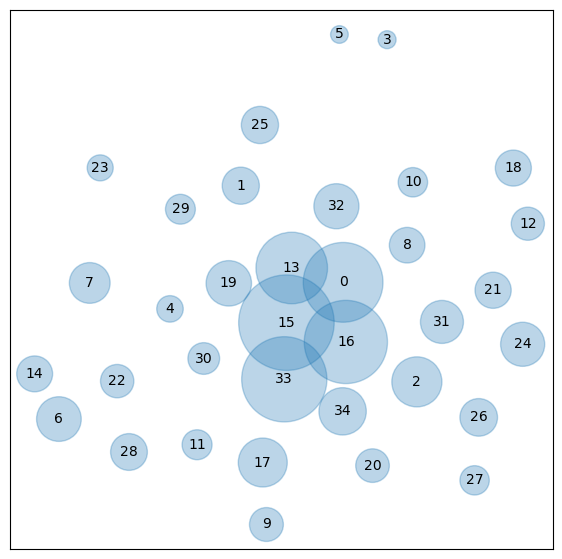

In [27]:
plot_topics(mdl)

I have tried number of topics ranging from 25 to 70 and finally settled here.

In [28]:
for k in range(mdl.k):
    print(f"{k:3d} ", ", ".join(s for s, _ in mdl.get_topic_words(k)))

  0  fuck, fucking, yeah, guy, man, dude, love, oh, maybe, literally
  1  police, gun, guns, cops, blm, violence, protest, antifa, killed, protests
  2  power, left, control, system, political, society, freedom, america, capitalism, war
  3  please, contact, submission_statement, removed, received, include, added, receive, responses, subsequently
  4  911, building, plane, planes, fire, collapse, buildings, steel, wtc, hit
  5  np, please, contact, automatically, performed, moderators_subreddit_questions_concerns, account, domain, required, protect
  6  vaccine, vaccines, covid, vaccinated, vaccination, vax, getting, shot, medical, unvaccinated
  7  1, 2, year, 5, 3, million, number, 6, 10, 4
  8  q, conspiracy, truth, conspiracies, real, true, alex_jones, 911, stuff, conspiracy_theories
  9  data, google, phone, internet, facebook, information, youtube, using, access, tech
 10  media, news, propaganda, cnn, article, msm, story, fake_news, tv, narrative
 11  water, oil, energy, gas, ca

In [29]:
import textwrap


def print_topic_docs(topic, n_best=3):
    topic_weights = sorted(
        [(doc.get_topic_dist()[topic], i) for i, doc in enumerate(mdl.docs)],
        reverse=True,
    )
    for i in range(n_best):
        print(
            textwrap.indent(
                textwrap.fill(df["text"].iloc[topic_weights[i][1]], width=100), "  "
            )
        )
        print()

In [31]:
print_topic_docs(2)

  tire pretty easy show sun gives uv radiation likewise easy show uv radiation damages soft tissue eye
  also goo like staring sun right sunset sunrise apparently good pineal gland ive read definitley
  feels nice gets fully horizon stop looking starts getting bright enough start hurting eyes nostaring
  television makes blind go blind ill blinking crescents weeks see solar eclipse open sun full power
  around 200 pm pretty hard keep eyes open force eyes open tears start gushing small negative effect
  seeing little light spot hours

  decipticon variant sounds scarier flag variant

  15 inches display plain day nothing cred new world order scum lot household items ingredients also
  used production stuff goes boom makeup would good example dont forget radiation scanners go medical
  test drive dont think timing suspicious detroit went pr problems police open access buisness
  security cameras city project green light month ago already used articles coverage started happening
  guess w

In [32]:
mdl.save("reddit-topics.bin")

In [33]:
topic_words = [[x for x, _ in mdl.get_topic_words(i)] for i in range(mdl.k)]
topics = pd.DataFrame(
    {
        "label": [x[0].upper() for x in topic_words],
        "words": [", ".join(x) for x in topic_words],
    }
)
topics.to_csv("labels.csv", index=False)

In [34]:
from cytoolz import *
from tqdm.auto import tqdm

tqdm.pandas()

mdl = tp.LDAModel.load("reddit-topics.bin")
labels = list(pd.read_csv("labels.csv")["label"])

In [39]:
df["doc"] = [mdl.make_doc(words=toks) for toks in df["tokens"]]
topic_dist, ll = mdl.infer(df["doc"])

  0%|          | 0/19969 [00:00<?, ?it/s]

Uncaughted c++ exception: Either `words` or `rawWords` must be filled.


RuntimeError: Either `words` or `rawWords` must be filled.

In [38]:
df["text"].iloc[0]

'Your post has been removed because it does not contain a submission statement If you think you received this message in error, or if you have subsequently added a submission statement, please contact the mods through modmail, and include a link to the comment with your submission statement This is a bot replies and PMs will not receive responses'

In [39]:
df["doc"].iloc[0].get_topics(top_n=5)

[(12, 0.7719322443008423),
 (24, 0.028013017028570175),
 (16, 0.027446961030364037),
 (47, 0.01871667057275772),
 (28, 0.01768597401678562)]

In [40]:
mdl.get_topic_words(17)

[('np', 0.04939240217208862),
 ('reddit', 0.04398369416594505),
 ('np_domain', 0.03350432217121124),
 ('account', 0.03331651911139488),
 ('please', 0.03192678093910217),
 ('accounts', 0.03151361644268036),
 ('protect', 0.03147605434060097),
 ('required', 0.03140093386173248),
 ('concerns', 0.03083752654492855),
 ('subreddit', 0.03083752654492855)]

In [41]:
mdl.get_topic_words(31)

[('epstein', 0.06750713288784027),
 ('him', 0.03953911364078522),
 ('trump', 0.036662399768829346),
 ('island', 0.01857108622789383),
 ('epsteins', 0.013968349434435368),
 ('x200b', 0.012018578127026558),
 ('maxwell', 0.011187529191374779),
 ('also', 0.010164698585867882),
 ('pedo', 0.009333648718893528),
 ('involved', 0.009205794893205166)]

In [42]:
[(labels[x], y) for x, y in df["doc"].iloc[0].get_topics(top_n=5)]

[('SUBMISSION_STATEMENT', 0.7719322443008423),
 ('COULD', 0.028013017028570175),
 ('GOING', 0.027446961030364037),
 ('LOL', 0.01871667057275772),
 ('HAD', 0.01768597401678562)]

In [45]:
df["topics"] = [
    [labels[t] for t in map(first, d.get_topics(3))] for d in df["doc"]
]

In [47]:
topic_freq = Counter(concat(df["topics"]))
topic_freq.most_common()

[('COULD', 10001),
 ('GOING', 9392),
 ('HAD', 5289),
 ('LOL', 4921),
 ('OUR', 3009),
 ('SAID', 2944),
 ('U_R_L', 2568),
 ('SUBMISSION_STATEMENT', 1841),
 ('HIM', 1688),
 ('MONEY', 1185),
 ('SUB', 1163),
 ('RUSSIA', 1050),
 ('VACCINE', 943),
 ('TRUMP', 922),
 ('LIFE', 819),
 ('CHINA', 775),
 ('GOVERNMENT', 751),
 ('CIA', 717),
 ('USE', 694),
 ('PLEASE', 669),
 ('SEE', 636),
 ('VIDEO', 591),
 ('GOD', 529),
 ('COVID', 522),
 ('MEDIA', 514),
 ('FOOD', 508),
 ('WATER', 454),
 ('CASE', 450),
 ('SCIENCE', 429),
 ('RIGHT', 413),
 ('ISRAEL', 381),
 ('VOTE', 346),
 ('EARTH', 306),
 ('BUILDING', 304),
 ('NP', 302),
 ('SHE', 292),
 ('PIZZAGATE', 275),
 ('POLICE', 249),
 ('WHITE', 245),
 ('EPSTEIN', 208),
 ('WOMEN', 180),
 ('Q', 163),
 ('KIDS', 143),
 ('MASKS', 126)]

In [48]:
for i in topics["label"]:
    for key in topic_freq:
        topics.loc[topics["label"]==key, "topics_frequency"] = topic_freq[key]

topics.to_csv("labels.csv", index=False)
topics

,label,words,topics_frequency
0,OUR,"our, aliens, humans, years, into, theory, beli...",3009.0
1,POLICE,"police, blm, violence, protest, antifa, protes...",249.0
2,OUR,"our, power, world, those, society, control, th...",3009.0
3,VACCINE,"vaccine, vaccines, covid, vaccinated, getting,...",943.0
4,PLEASE,"please, bot, moderators, questions, subreddit,...",669.0
5,MEDIA,"media, news, propaganda, article, cnn, story, ...",514.0
6,VOTE,"vote, election, votes, voting, bernie, fraud, ...",346.0
7,COVID,"covid, virus, flu, covid19, test, deaths, had,...",522.0
8,SCIENCE,"science, study, u_r_l, studies, research, scie...",429.0
9,Q,"q, twitter, tweet, trump, qanon, tweets, now, ...",163.0


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

topic_id = 20
topic_words = mdl.get_topic_words(topic_id, top_n=50)

wordcloud = WordCloud(background_color="white").generate_from_frequencies(dict(topic_words))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

topic_id = 2
topic_words = mdl.get_topic_words(topic_id, top_n=50)

wordcloud = WordCloud(background_color="white").generate_from_frequencies(dict(topic_words))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Plotting topic prevalence over time
First, add topic distributions to the dataframe

In [50]:
%%time

docs = [mdl.make_doc(words=toks) for toks in df["tokens"]]
topic_dist, ll = mdl.infer(docs)
topics = [d.get_topic_dist() for d in docs]

CPU times: user 1min 28s, sys: 62.1 ms, total: 1min 28s
Wall time: 25.1 s


<AxesSubplot: xlabel='date'>

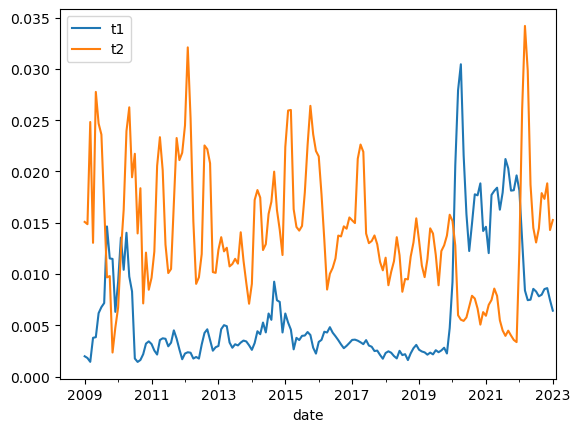

In [52]:
df["t1"] = [t[7] for t in topics]
df["t2"] = [t[42] for t in topics]
df.resample("M", on="date")[['t1','t2']].mean().rolling(3, center=True).mean().plot()

In [ ]:
df["t1"] = [t[7] for t in topics]
df["t2"] = [t[42] for t in topics]
df.resample("M", on="date")[['t1','t2']].mean().rolling(3, center=True).mean().plot()

## SUMMARY


I have generated the list of labels. I have used LDA to do topic modeling. In the hyper-parameters for LDA, I have chosen k value of 50 and the minimum frequency of words to be excluded (min_df = 125) and rm_top = 75. I have calculated the topic frequency score of each label and the all the words that belong to that topic. Next, I calculated the topic prevalence of certain topics over time. I have selected 4 topics and compared two topics each over the last decade. I have done monthly and yearly analysis as well. I have selected COVID and RUSSIA labels and compared them over the past decade filtering the df.resample method and grouping by year and month. I used rolling average method to smoothen the graph. Understandably COVID topic hit peak during 2020. RUSSIA is always a hot topic in conspiracy theories. It has various highs and hit its peak during 2022 Russia-Ukraine war. Later, I have selected the labels ISRAEL and CIA. The topic ISRAEL reached its peak in 2011 and 2018, while CIA topic hit peaks during 2009 and 2018. The interesting observation is both these topics hit peaks during the same time period. 
